In [ ]:
import os
import io
import json
import keras
import numpy             as np
import pandas            as pd
import tensorflow        as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from PIL         import Image
from tqdm        import tqdm
from scipy.stats import norm
from tabulate    import tabulate
from keras       import layers,models

## Define the problem and the Labels

We will create a continuum flux at $1$, with some Gaussian absorbers in it.
<br>
All the "pixels" belonging to the continuum are labeled as $0$.
<br>
All the "pixels" belonging to the absorbers are labeled as $1$.

Text(0.5, 1.0, 'Labelling criteria example')

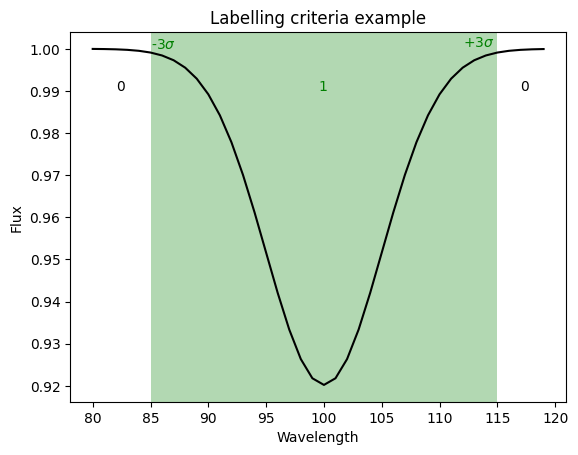

In [ ]:
center = 100
sigma = 5

x = np.arange(center - 4 * sigma, center + 4 * sigma, 1)
gaussian = norm.pdf(x, center, sigma)

# Plot
plt.plot(x, 1-gaussian, color='black')

plt.text(center - 3 * sigma, 1-norm.pdf(center - 3 * sigma, center, sigma)+0.001, r'-3$\sigma$', color='green')
plt.text(center + 3 * sigma -3, 1-norm.pdf(center + 3 * sigma -3, center, sigma)+0.005, r'+3$\sigma$', color='green')

plt.axvspan(center - 3 * sigma, center + 3 * sigma, facecolor='green', alpha=0.3)

plt.text(82, 0.99, r'$0$', color='black')
plt.text(117, 0.99, r'$0$', color='black')

plt.text(99.5, 0.99, r'$1$', color='green')

plt.xlabel('Wavelength')
plt.ylabel('Flux')
plt.title('Labelling criteria example')

## Single example

First, we see how to add a single Gaussian aborber to the continuum.
<br>
Create a wavelength array from $0$ to $999$, with spacing $= 1$. We assume the wavelength can then be mapped exactly on this array.

Create a flux at $1$. We want to add gaussian absorption lines. We use scipy.stats.norm.
<br>
The probability density function for **norm.pdf(x, loc, scale)** is
$$
f(x) = \frac{1}{scale \sqrt{2\pi}} \cdot exp\left[{-\frac{1}{2}\left(\frac{(x - loc)}{scale}\right)^2}\right]
$$
<br>
with **loc = mean**  and **scale = standard deviation**.
<br>
Their position and standar deviation are sampled uniformly at random.

In [ ]:
wavelength = np.arange(0,1000,1)
flux = np.zeros(len(wavelength)) + 1.0

# Number of gaussian absorber to insert
# For this example we only insert one
number = 2

# Randomly sample std and initialize the position array
sigma    = np.random.uniform(0.5,5,number)
position = np.zeros(number)

# Create a segmentation mask for each 'pixel' of the wavelength array
# 0 = nothing    1 = absorber
segmentation_mask = np.zeros(len(wavelength))

temp = 0
while temp<number:

    # For sampling the positions, stay 3 sigma from the edges at least
    position_temp = np.random.randint(min(wavelength)+3*sigma[temp],max(wavelength)-3*sigma[temp])
    strength_temp = np.random.uniform(1,250)

    # Proceed only if the new position is not overlapping another absorber
    if all( element==0 for element in segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])]):

        # Save the new position center
        position[temp] = position_temp

        # Create the gaussian absorber as an optical depth array, then apply it to the flux
        tau = strength_temp*norm.pdf(wavelength, position_temp, sigma[temp])
        flux *= np.exp(-tau)

        # Clip the flux to make a line saturated if it goes below 0
        #flux = np.clip(flux, 0, None)

        # Update segmentation mask
        segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])] = 1

        print('Generated Gaussian absorber at {:3.2f} pix, with sigma {:3.2f} pix and amplitude {:3.2f}'.format(position[temp], sigma[temp], strength_temp))

        temp += 1

Generated Gaussian absorber at 376.00 pix, with sigma 2.85 pix and amplitude 106.00
Generated Gaussian absorber at 86.00 pix, with sigma 2.00 pix and amplitude 231.68


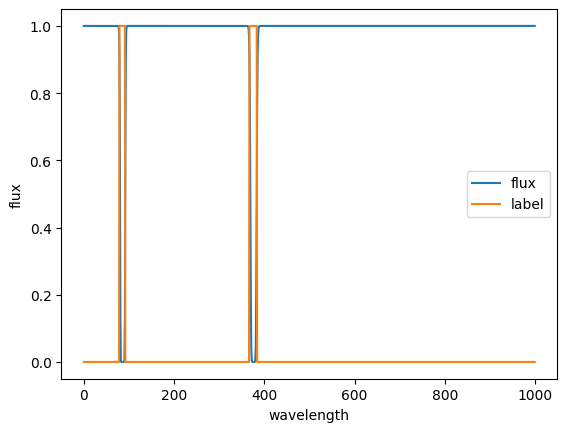

In [ ]:
# Plot
plt.plot(wavelength,flux, label='flux')
plt.plot(wavelength, segmentation_mask, label='label')
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()

# The dataset

To built the dataset, we create N_sample spectra with different absorbers in it.

In [ ]:
N_sample = 15000

## Create spectra

Now, we also add random **gaussian noise** to the continuum.
<br>
Furthermore, we also randomly sample the **amplitude** of the absorbers.

In [ ]:
def create_spectrum(num_abs, snr):

    # Create a wavelength array
    wavelength = np.arange(0,1000,1)

    # Create a flux, at 1
    cont = snr**2
    flux = np.ones(len(wavelength)) * cont

    # Number of gaussian absorber to insert
    number = num_abs

    # Randomly sample amplitude, std and initialize position array
    A        = np.random.uniform(1,250,number)
    sigma    = np.random.uniform(0.5,5,number)
    position = np.zeros(number)

    # Create a segmentation mask
    # 0 = nothing    1 = absorber
    segmentation_mask = np.zeros(len(wavelength))

    temp = 0
    while temp<number:

        # For sampling the positions, stay 3 sigma from the edges at least
        position_temp = np.random.randint(min(wavelength)+3*sigma[temp],max(wavelength)-3*sigma[temp])

        # Proceed only if the new position is not overlapping another absorber
        if all( element==0 for element in segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])]):

            # Save the new position center
            position[temp] = position_temp

            # Create the gaussian absorber within 3 sigma from the center
            x        = np.arange(int(position_temp - 3 * sigma[temp]), int(position_temp + 3 * sigma[temp]), 1)

            # Here we multiply for the amplitude
            tau = A[temp] * norm.pdf(wavelength, position_temp, sigma[temp])

            # Update the flux array subtracting the gaussian absorber from the continuum
            flux *= np.exp(-tau)

            # Clip the flux to make a line saturated if it goes below 0
            #flux = np.clip(flux, 0, None)

            # Update segmentation mask
            segmentation_mask[int(position_temp-3*sigma[temp]):int(position_temp+3*sigma[temp])] = 1

            temp += 1

    noisy = 1.*np.random.poisson(flux)

    noisy /= cont

    return noisy, segmentation_mask

In [ ]:
# Randomly decide the number of absorbers for each sample
num_abs = np.random.randint(3,10, N_sample)
snr = 5

image   = []
mask    = []

# We loop over and create N_sample spectra
for i in tqdm(range(N_sample)):

    # Create the spectrum
    image_, mask_ = create_spectrum(num_abs[i], snr = snr)

    # Save the spectrum and the labels
    image.append(image_[:,np.newaxis])
    mask.append(np.array(mask_[:,np.newaxis]))

100%|██████████| 15000/15000 [00:39<00:00, 380.79it/s]


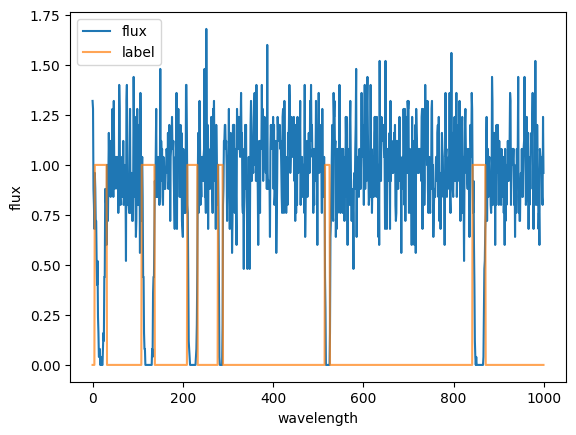

In [ ]:
# Plot an example spectrum
ind = np.random.choice(len(image))
plt.plot(wavelength, image[ind], label='flux')
plt.plot(wavelength, mask[ind], label='label', alpha = 0.7)
plt.xlabel('wavelength')
plt.ylabel('flux')
plt.legend()

In [ ]:
# Create the dataset with tensorflow
#dataset = tf.data.Dataset.from_tensor_slices((image,mask))

# as above, set the random seed to randomly split the images in a repeatable way. Try different values!
random_state = 42

X = np.asarray(image).astype('float32')
Y = np.asarray(mask).astype('float32')

# First split off 30% of the data for validation+testing
X_train, X_temp, Y_train, Y_temp = train_test_split(X, Y, test_size=0.3, random_state=random_state, shuffle=True)

# Then divide this subset into training and testing sets
X_valid, X_test, Y_valid, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=random_state, shuffle=True)

print(np.shape(X_train), np.shape(Y_train))

(10500, 1000, 1) (10500, 1000, 1)


# Model

We now built the U-net model.

## Convolutional layer

In [ ]:
# Filters is the number of kernels that will do the convolution. Each one will learn a different feature of the input
# So, high enough to see all the features, but low enough to prevent overfitting
# Kernel size is how much the filter is big. In this case it will be 3 pixel

# For the first layer we must specify the input shape so that it can initialized the weights;
# subsequent layers automatically infer the input shape from the output shape of the previous layer

# Initializers define the way to set the initial random weights of Keras layers.
# The he_normal kernel initializer draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 /n)
# where n is the number of input units in the weight tensor

# Here we do a double convolution

def double_convolution(x, num_f):

    x = layers.Conv1D(filters=num_f, kernel_size=3, padding='same', activation='relu', kernel_initializer = "he_normal")(x)
    x = layers.Conv1D(filters=num_f, kernel_size=3, padding='same', activation='relu', kernel_initializer = "he_normal")(x)

    return x

## Pooling layer

The pooling layer is to reduce the spatial size of the representation; to do that it does a statistic representation of nearby outputs.
<br>
For example, the max pooling layer we will use takes the maximum value out of the dimension of its filter.

In [ ]:
def encoder_block(x, num_f):

    x = double_convolution(x, num_f)
    y = layers.MaxPooling1D(pool_size=2, strides=2)(x)

    # Dropout block is to reduce over-fitting. We set some input at 0, so the info is ignored
    # how? with a certain probability. but only during training, not during inference
    y = layers.Dropout(0.4)(y)

    return x, y

## Bottleneck + upsampling

In [ ]:
def decoder_block(x, features, num_f):

    x = layers.Conv1DTranspose(filters=num_f, kernel_size=2, padding='same', strides=2, activation='relu')(x)

    x = layers.concatenate([x, features])

    x = layers.Dropout(0.4)(x)

    x = double_convolution(x, num_f)

    return x

## Final model

In [ ]:
def unet(input_size):

    inputs = layers.Input(input_size)

    x1, y1 = encoder_block(inputs, 32)

    x2, y2 = encoder_block(y1, 64)

    x3, y3 = encoder_block(y2, 128)

    bottleneck = double_convolution(y3, 256)

    up1    = decoder_block(bottleneck, x3, 128)

    up2    = decoder_block(up1, x2, 64)

    up3    = decoder_block(up2, x1, 32)

    # 'linear' so that the outputs values are not modified
    # the final output has the same shape as the initial input
    # filter is the number of classes, in our case 2 (zero or one)
    outputs = layers.Conv1D(filters=2, kernel_size=1, activation='linear')(up3)

    u_net = tf.keras.Model(inputs, outputs, name='U-Net')

    return u_net

To compute the shape of the output after a convolutional or pooling layer:
$$
    output = \frac{input - kernel\_size + 2*padding}{stride} + 1
$$
after a transpose convolutional layer:
$$
    output = (input - 1) * stride + kernel\_size - 2*padding
$$
<br>
$stride$ is how many pixel we move at each iteration of the convolution between kernel and image. The default is $1$.
<br>
$padding$ is to mantain the dimension of the output equal to the one of the input.

In [ ]:
model = unet((1000,1))

To see the model and the "U" shape

In [ ]:
scheme = tf.keras.utils.plot_model(model, show_shapes=True)

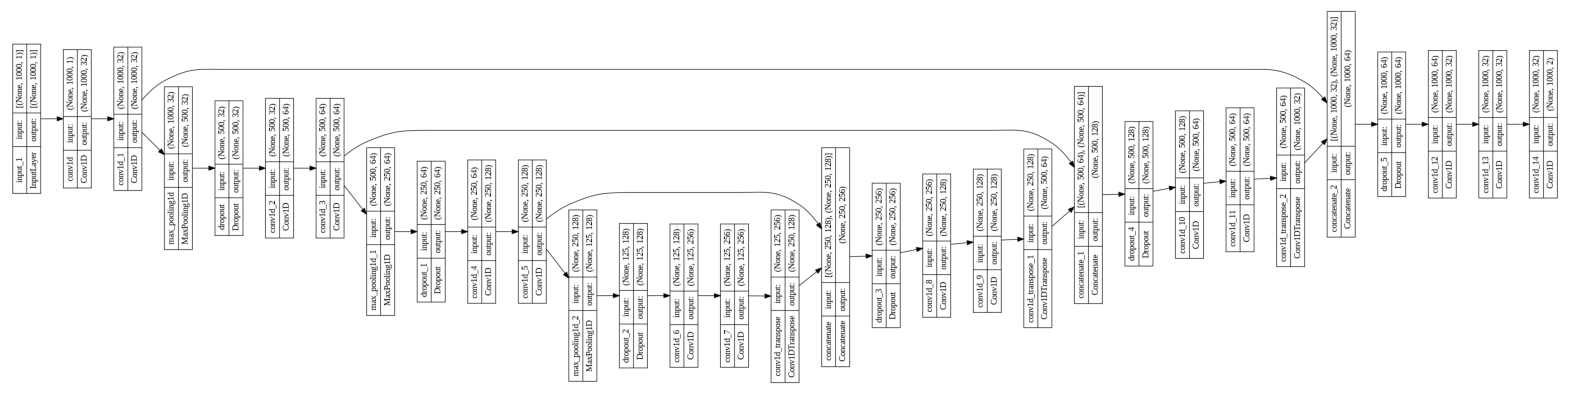

In [ ]:
# "U - shape"
scheme_  = Image.open(io.BytesIO(scheme.data))
scheme_h = scheme_.rotate(90, expand=True)

plt.figure(figsize=(20,5))
plt.imshow(scheme_h)
plt.axis('off')
plt.show()

# Training

$$
J(w) = -\frac{1}{N} ∑_{i=1}^N [y_i log(\hat{y_i}) + (1-y_i) log(1-\hat{y_i})]
$$
<br>
where $y_i$ is the true label and $\hat{y_i}$ is the predicted label.

In [ ]:
# Use CategoricalCrossentropy when labels are in one-hot representation, SparseCategoricalCrossentropy when they are numbers

# from_logits=True  means that the model predictions are from [-inf, +inf]
# from_logits=False means that the model predictions are from [0,1], so a probability

# The loss function handels itself the conversion from logits to probabilities

model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=["accuracy"])


Save the dataset in train and test datasets.

In [ ]:
nb_epoch = 50
batch_size = 128
shuffle = True

# Train
history = model.fit(X_train, Y_train,
                  batch_size=batch_size,
                  epochs=nb_epoch,
                  validation_data=(X_valid, Y_valid),
                  shuffle=shuffle,
                  verbose=True)#,callbacks = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5))

Epoch 1/50
83/83 [==============================] - 20s 98ms/step - loss: 0.1819 - accuracy: 0.9201 - val_loss: 0.0668 - val_accuracy: 0.9778
Epoch 2/50
83/83 [==============================] - 6s 72ms/step - loss: 0.0570 - accuracy: 0.9812 - val_loss: 0.0387 - val_accuracy: 0.9866
Epoch 3/50
83/83 [==============================] - 6s 77ms/step - loss: 0.0402 - accuracy: 0.9860 - val_loss: 0.0258 - val_accuracy: 0.9905
Epoch 4/50
83/83 [==============================] - 6s 76ms/step - loss: 0.0320 - accuracy: 0.9887 - val_loss: 0.0267 - val_accuracy: 0.9903
Epoch 5/50
83/83 [==============================] - 6s 77ms/step - loss: 0.0287 - accuracy: 0.9898 - val_loss: 0.0255 - val_accuracy: 0.9906
Epoch 6/50
83/83 [==============================] - 6s 74ms/step - loss: 0.0271 - accuracy: 0.9903 - val_loss: 0.0224 - val_accuracy: 0.9918
Epoch 7/50
83/83 [==============================] - 6s 78ms/step - loss: 0.0259 - accuracy: 0.9907 - val_loss: 0.0244 - val_accuracy: 0.9913
Epoch 8/50
8

# Learning Curve

In [ ]:
# List all data in history
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [ ]:
def display_learning_curves(history):

    acc      = history["accuracy"]
    val_acc  = history["val_accuracy"]

    loss     = history["loss"]
    val_loss = history["val_loss"]

    print(len(acc))
    epochs_range = np.arange(len(acc))

    fig = plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(epochs_range, acc, label="train accuracy")
    plt.plot(epochs_range, val_acc, label="validation accuracy")
    plt.ylim(0.5,1)
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_range, loss, label="train loss")
    plt.plot(epochs_range, val_loss, label="validation loss")
    plt.ylim(0,0.5)
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    fig.tight_layout()
    plt.show()

50


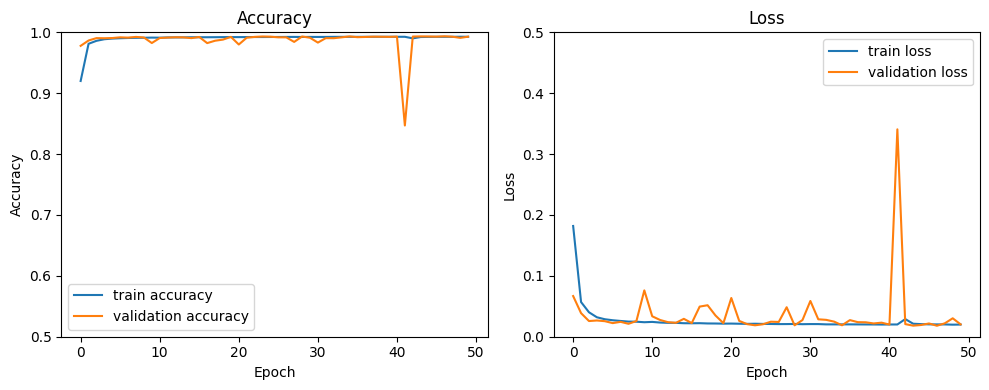

In [ ]:
# Display learning curves
display_learning_curves(history.history)

# Analysis on the test dataset

## Predictions

In [ ]:
# In classification tasks, the predicted masks contain probability for each pixels
# so, to know which is the preticted class we take the maximum value of the 2 different masks
def create_mask(pred_mask):

    # axis=-1 because remember that dimension = [batch_size, pixels, features]
    pred_mask = tf.argmax(pred_mask, axis=-1)

    return pred_mask[0]

(1000, 1)
1/1 [==============================] - 1s 866ms/step


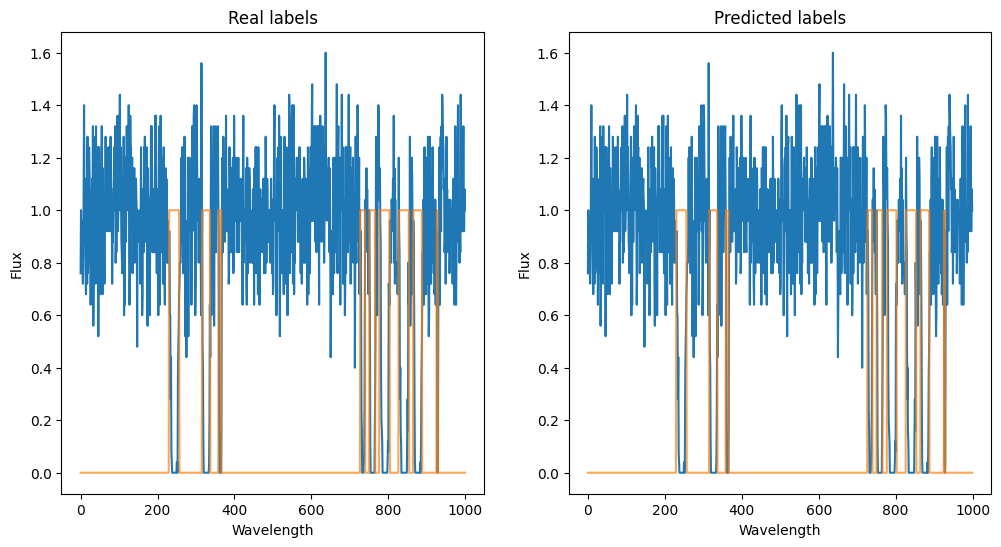

(1000, 1)
1/1 [==============================] - 0s 26ms/step


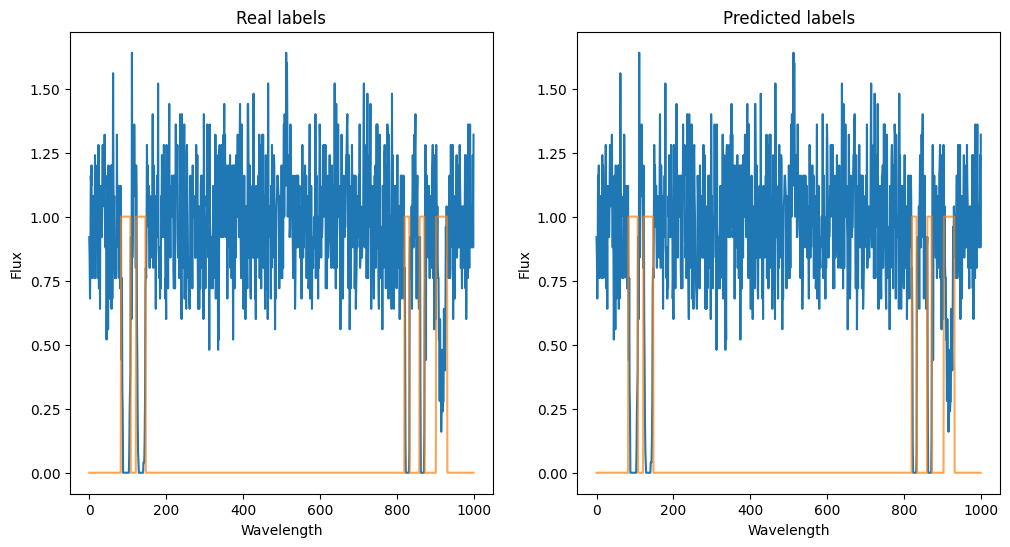

In [ ]:
# Create a wavelength array
wavelength = np.arange(0,1000,1)
i = 0
for ind in range(2):

    image = X_test[ind]
    mask = Y_test[ind]

    print(np.shape(image))

    # the test are not batched, we need to add a new axis because the model expects also a batch size
    # with this, we predict the mask using the trained model
    pred_mask = model.predict(image[tf.newaxis, ...])

    # Plot
    fig = plt.figure(figsize=(12,6))

    plt.subplot(1,2,1)
    plt.plot(wavelength, image)
    plt.plot(wavelength,mask, alpha=0.7)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title('Real labels')

    plt.subplot(1,2,2)
    plt.plot(wavelength, image)
    plt.plot(wavelength,create_mask(pred_mask), alpha=0.7)
    plt.xlabel('Wavelength')
    plt.ylabel('Flux')
    plt.title('Predicted labels')

    i += 1

    plt.show()

Predictions for all the spectra in the test dataset

In [ ]:
predictions = []

for ind in range(len(X_test)):

    image = X_test[ind]

    pred_mask = model.predict(image[tf.newaxis,...], verbose=False)
    pred_mask = tf.argmax(pred_mask, axis=-1)
    predictions.append(pred_mask[0].numpy())

## Confusion matrix

To understand the recovery of the absorption lines, we can compute a confusion matrix with the true and predicted labels.

In [ ]:
real_label = []
confusion_matrix = []

i = 0

for ind in range(len(X_test)):

    real_label.append(Y_test[ind].flatten())
    if (i==0):
        confusion_matrix = tf.math.confusion_matrix(Y_test[ind].flatten(), predictions[i], num_classes = 2)
    else:
        confusion_matrix += tf.math.confusion_matrix(Y_test[ind].flatten(), predictions[i], num_classes = 2)
    i+=1

In [ ]:
classes = ['0', '1']
a = confusion_matrix.numpy()
a_ = [[str(cell) for cell in row] for row in a]
horizontal = ['True  /  Pred'] + classes
tabella = [[col] + row for col, row in zip(classes, a_)]
tabulate(tabella, headers = horizontal, tablefmt='html', numalign='center')

True / Pred,0,1
0,2014653,9771
1,6575,219001


From this, we can calculate the **completness**(or recall) and **purity** (or precision) as <br>

$$
completness = \frac{TP}{TP + FN} \qquad \qquad purity = \frac{TP}{TP + FP}
$$

In [ ]:
print('Completness = ', int(tabella[1][2]) / (int(tabella[1][2]) + int(tabella[1][1])))
print('Purity = ', int(tabella[1][2]) / (int(tabella[1][2]) + int(tabella[0][2])))

Completness =  0.9708523956449268
Purity =  0.9572893535922228


But computed in this way, we consider only the single pixels.
<br>
If we want to know the recovery of the absorption lines as a whole, we need to consider a group of pixels as a single detection.

In [ ]:
# It returns a list with the start and end index of all the sequences of 1 in 'sequence'
def find_1 (sequence):
    flag = False
    lista = []
    i = 0
    while (i<(len(sequence))):
        if (sequence[i]==0):
            i +=1
        else:
            start = i
            j = i+1
            if (j == len(sequence)):
                lista.append((start,start))
                break
            else:
                while(sequence[j]==1):
                    j+=1
                    if(j == len(sequence)):
                        lista.append((start,j-1))
                        flag = True
                        break
                if flag:
                    break
                end = j-1
                i += (end-start)+1
                lista.append((start,end))
    return lista

In [ ]:
TP = 0
TN = 0
FP = 0

# Loop over all the spectra
for i in tqdm(range(len(real_label))):

    # Find start and end of cluster of 1 in the predicted labels
    lista_pred = find_1(predictions[i])

    # Loop over the clusters of 1
    for h in lista_pred:

        # Compute purity
        if all(predictions[i][h[0]:h[1]+1] != real_label[i][h[0]:h[1]+1]):

            FP += 1
    #______________________________________________________________________


    # Find start and end of cluster of 1 in the true labels
    lista_true = find_1(real_label[i])

    # Loop over the clusters of 1
    for j in lista_true:

        # Compute completeness
        if all(predictions[i][j[0]:j[1]+1] == real_label[i][j[0]:j[1]+1]):

            TP += 1

        else:

            FN += 1

  0%|          | 0/2250 [00:00<?, ?it/s]


NameError: name 'FN' is not defined

In [ ]:
completeness = TP / (TP + FN)
purity       = TP / (TP + FP)
print('Completness = ', completeness)
print('Purity = ', purity)

We can also compute the **F1 score**, which is the measure of the accuracy of the predictions.

$$
F1 = \frac{2 \cdot completeness \cdot purity}{completeness + purity}
$$

In [ ]:
F_1 = 2 * completeness * purity / (completeness + purity)
print('F1 score = ',F_1)